# Ansys processing pipeline

In [1]:
import time
import sympy
import pickle
import chaospy
import warnings
import numpy as np
import pandas as pd
import pyvista as pv
from tqdm import tqdm
import seaborn as sns
from matplotlib import cbook
from pyvista import CellType
from polychaos import metrics
import matplotlib.pyplot as plt
from sklearn import linear_model as lm

np.random.seed(100)

%matplotlib inline
pv.global_theme.cmap = 'jet'
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'
sns.set_context('notebook', font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('bright')
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

Define the distributions applied to the plate.

In [2]:
# Train and test set sizes
N_train = 250
N_test = 50

# Force distribution parameters
scale = 7.5e3
shift_F = 50e3

# Pressure distribution parameters
mu = 12
sigma = 0.25
shift_P = 10e7

# Distributions
F = chaospy.Exponential(scale, shift_F)
P = chaospy.LogNormal(mu, sigma, shift_P)
joint = chaospy.J(F, P)

# Samples
samples = joint.sample(N_train + N_test, rule='sobol').T
train_input = samples[:N_train]
test_input = samples[N_train:]

Plot the experimental design.

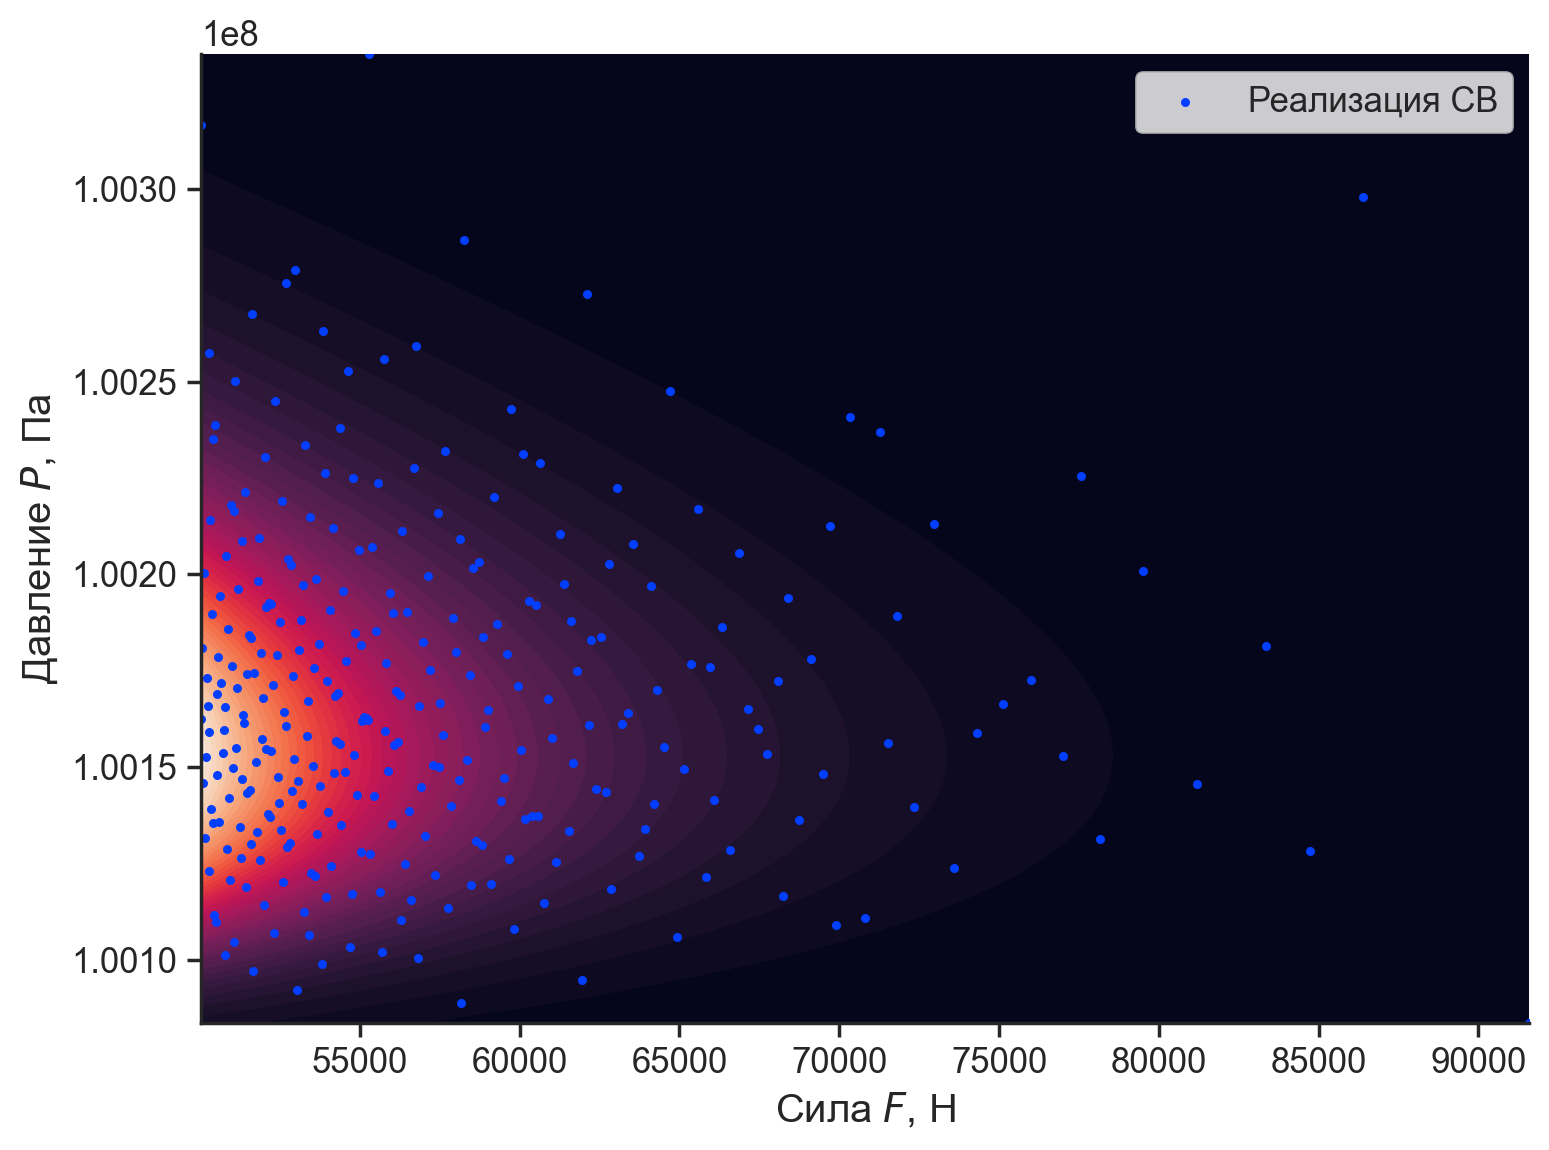

In [3]:
levels = 50
grid = np.mgrid[min(samples[:, 0]):max(samples[:, 0]):100j,
                min(samples[:, 1]):max(samples[:, 1]):100j]
plt.contourf(grid[0], grid[1], joint.pdf(grid), levels)
plt.scatter(*samples.T, s=5, label='Реализация СВ')
plt.xlabel('Сила $F$, Н')
plt.ylabel('Давление $P$, Па')
plt.legend()
plt.show()

Write the sample to the file.

In [4]:
# np.savetxt(r'files/input.csv', samples, delimiter=',')

Define a function to read pickle file.

In [5]:
def load_pickle(filename):
    with open(filename, 'rb') as f:
        res = []
        pbar = tqdm()
        
        while True:
            try:
                res.append(pickle.load(f))
                pbar.update(1)
            except EOFError:
                break
                
    return np.array(res)

In [6]:
# Mesh statistics
n_nodes = 1588
n_elems = 5029

Return the model response.

In [7]:
evals = load_pickle(r'files/output.pickle')
train_output = evals[:N_train]
test_output = evals[N_train:]

300it [00:01, 260.64it/s]


Build a polynomial chaos metamodel.

In [8]:
# Normalize inputs for better precision 
train_input_normed = (train_input - np.mean(train_input, axis=0))/np.std(train_input, axis=0)
test_input_normed = (test_input - np.mean(train_input, axis=0))/np.std(train_input, axis=0)

# Define the PCE expansion
expansion = chaospy.generate_expansion(2, joint, normed=True)

kws = {"fit_intercept": False}
# Train the regression model
# approx_solver = chaospy.fit_regression(expansion, train_input_normed.T, train_output)
approx_solver = chaospy.fit_regression(expansion, train_input_normed.T, train_output,
                                       model=lm.Ridge(alpha=0.05, **kws))

Print the trained metamodel.

In [9]:
approx_solver.round(4)

polynomial([[0.0102*q0*q1+0.0001*q0**2+584.6021*q1-1017015.0504*q0-52528531.6664,
             0.0506*q0*q1+0.0005*q0**2+2907.6356*q1-5068863.9685*q0+59621206.5678],
            [0.0011*q0*q1+66.8645*q1-115130.4625*q0-42304604.1871,
             0.0283*q0*q1+0.0003*q0**2+1628.2602*q1-2839257.2581*q0+55340173.4687],
            [-0.0365*q0*q1-0.0004*q0**2-2096.9507*q1+3653228.1853*q0+29293132.9832,
             0.0236*q0*q1+0.0002*q0**2+1354.9997*q1-2362033.5013*q0+23842360.4993],
            ...,
            [0.0001*q1**2-0.1626*q0*q1-0.0017*q0**2-9349.0646*q1+16288123.4241*q0+114253225.5466,
             -0.0631*q0*q1-0.0007*q0**2-3628.4085*q1+6321522.8962*q0+43168092.895],
            [0.0001*q1**2-0.2051*q0*q1-0.0022*q0**2-11792.8345*q1+20546340.0314*q0+124843599.6356,
             -0.061*q0*q1-0.0006*q0**2-3506.0256*q1+6108401.7043*q0+38726985.3769],
            [0.0001*q1**2-0.1958*q0*q1-0.0021*q0**2-11256.586*q1+19612124.4544*q0+116860094.4028,
             -0.055*q0*q1-0.0006*q0

Test the polynomial chaos metamodel.

In [10]:
chaos_output = approx_solver(*test_input_normed.T).transpose(2, 0, 1)

Plot the regression results.

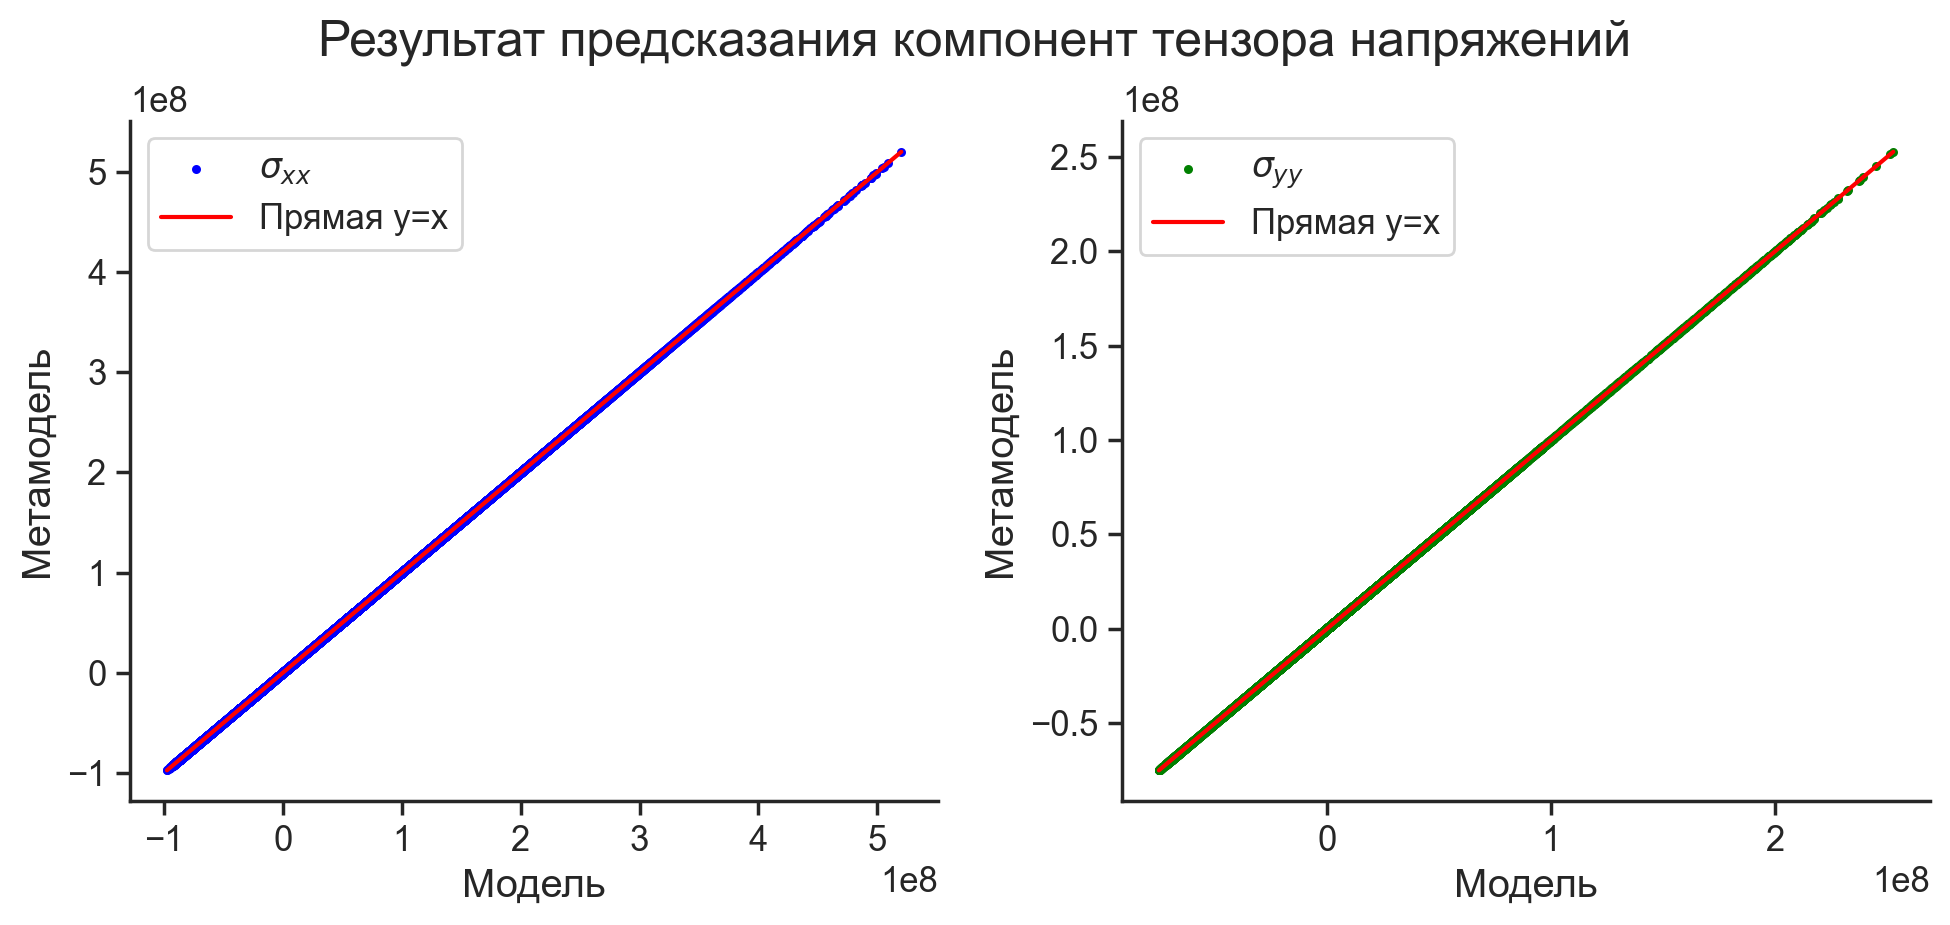

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(N_test):
    if i == 0:
        ax[0].scatter(test_output[i, :, 0], chaos_output[i, :, 0], color='blue', marker='.',
                      label='$\sigma_{xx}$', s=20)
        ax[1].scatter(test_output[i, :, 1], chaos_output[i, :, 1], color='green', marker='.',
                      label='$\sigma_{yy}$', s=20)
    else:
        ax[0].scatter(test_output[i, :, 0], chaos_output[i, :, 0], color='blue', marker='.', s=20)
        ax[1].scatter(test_output[i, :, 1], chaos_output[i, :, 1], color='green', marker='.', s=20)

ax[0].plot([np.min(test_output[..., 0]), np.max(test_output[..., 0])],
           [np.min(test_output[..., 0]), np.max(test_output[..., 0])],
           color ='red', label='Прямая y=x')
ax[0].set_xlabel('Модель')
ax[0].set_ylabel('Метамодель')
ax[0].legend()

ax[1].plot([np.min(test_output[..., 1]), np.max(test_output[..., 1])],
           [np.min(test_output[..., 1]), np.max(test_output[..., 1])],
           color ='red', label='Прямая y=x')
ax[1].set_xlabel('Модель')
ax[1].set_ylabel('Метамодель')
ax[1].legend()

fig.suptitle('Результат предсказания компонент тензора напряжений', y=0.93)
plt.tight_layout()
plt.show()

Microscope.

In [12]:
plt.style.use('default')
%config InlineBackend.figure_format='retina'
sns.set_context('notebook', font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('bright')

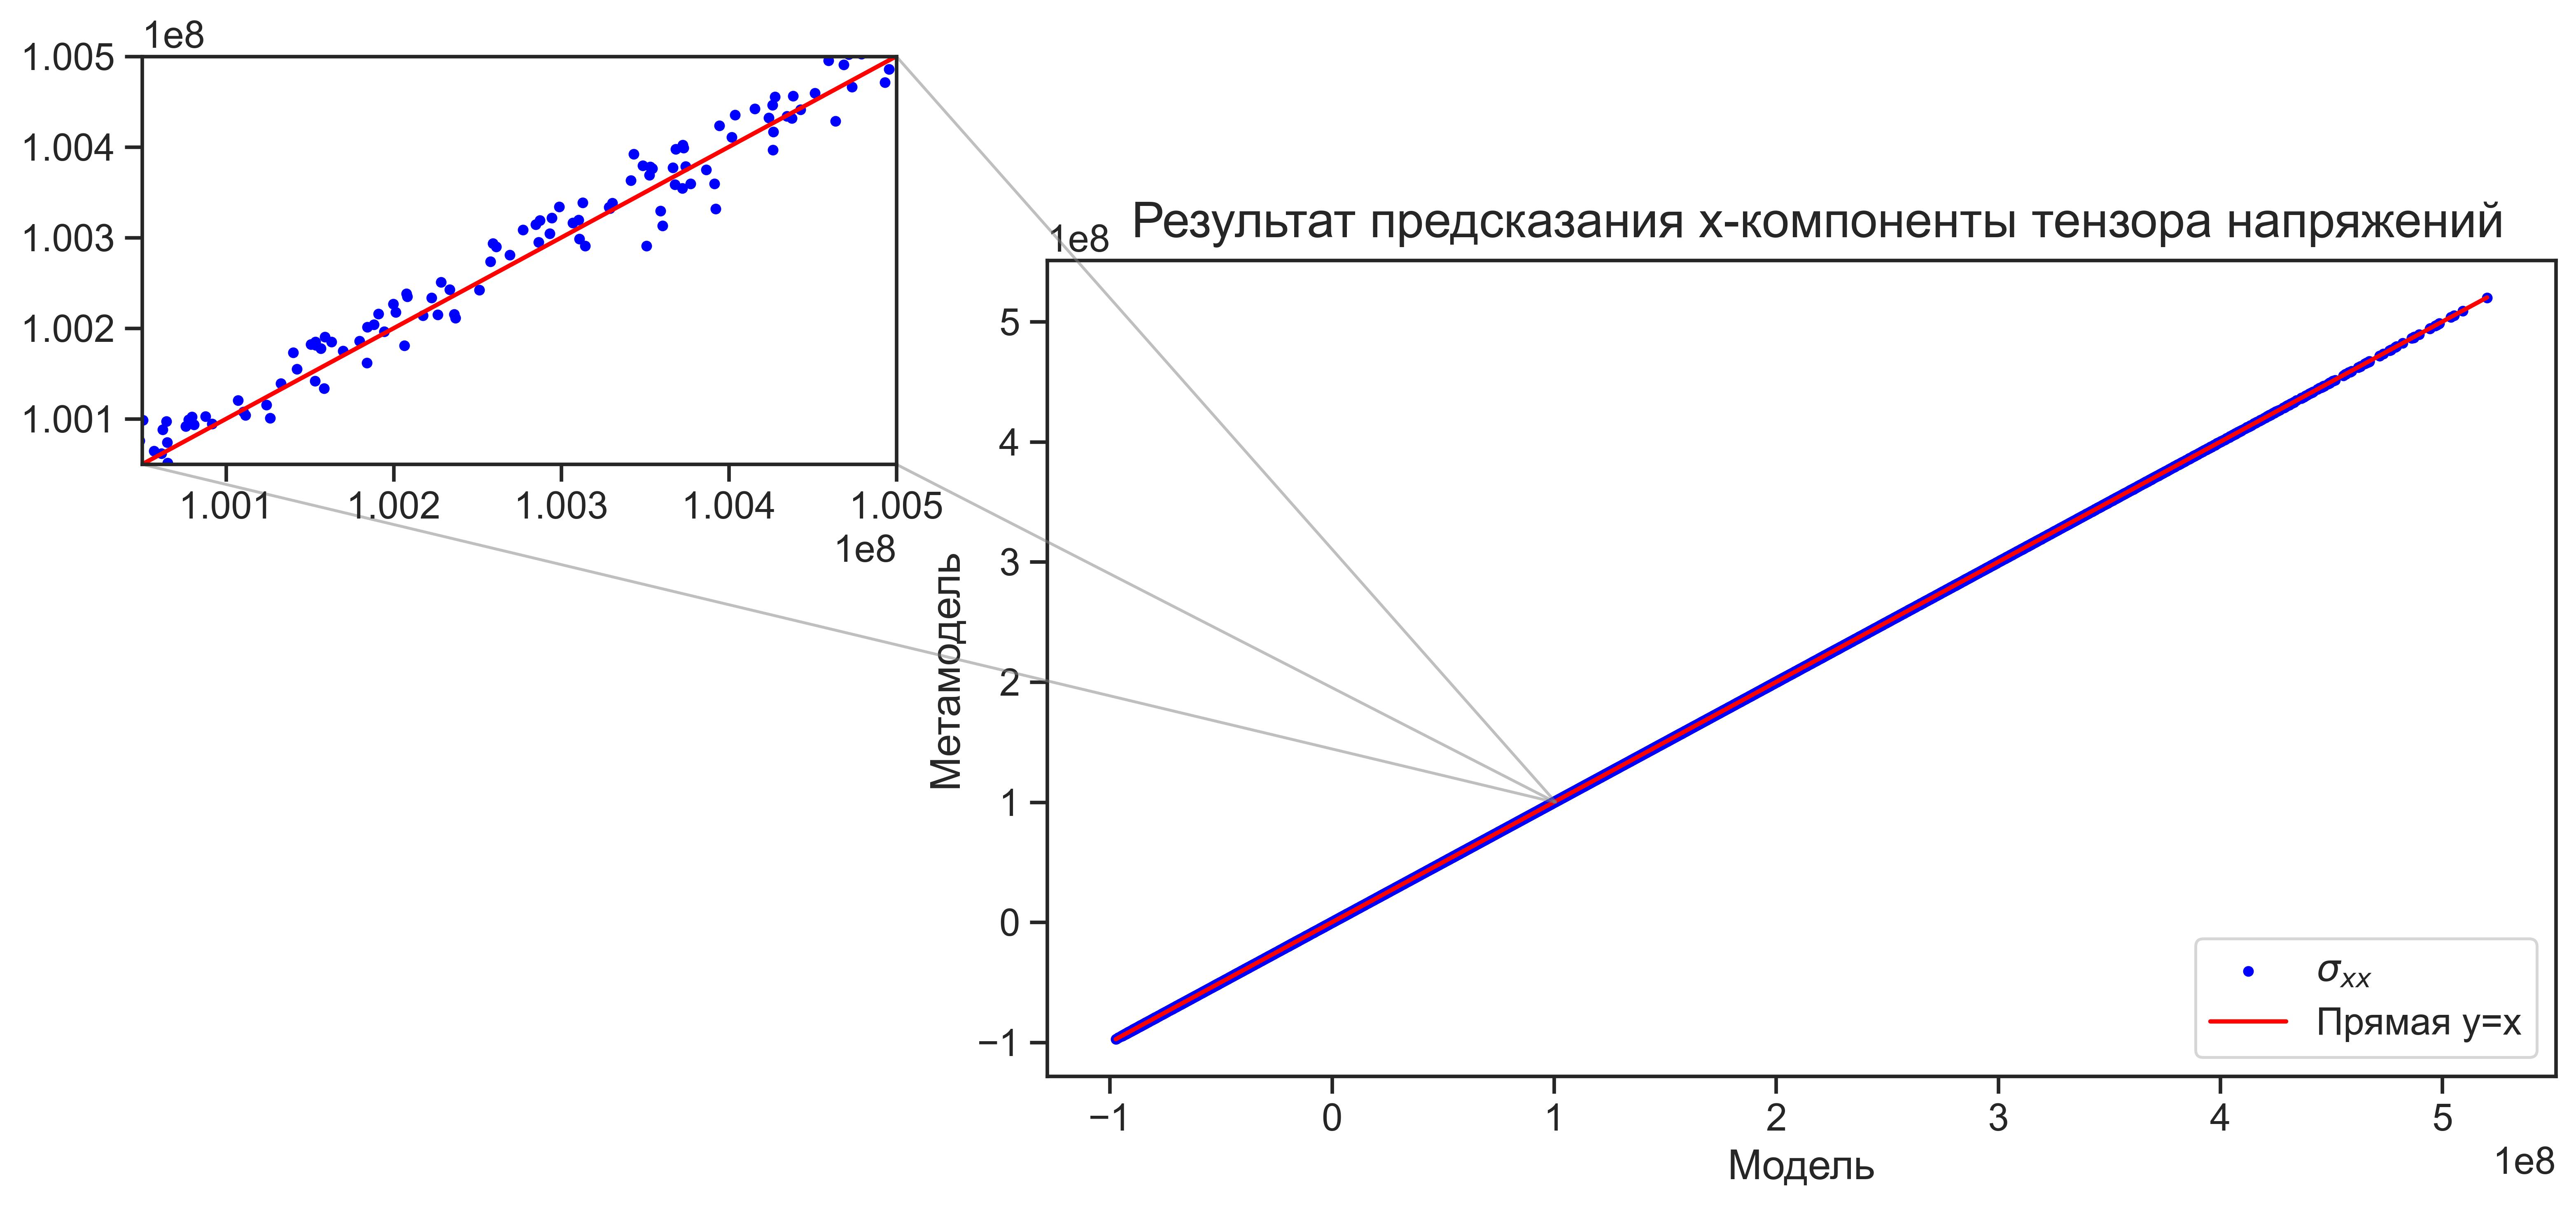

In [13]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=250)
axins = ax.inset_axes([-0.6, 0.75, 0.5, 0.5])


ax.scatter(test_output[0, :, 0], chaos_output[0, :, 0], color='blue', marker='.', label='$\sigma_{xx}$', s=30)
ax.scatter(np.ravel(test_output[1:, :, 0]), np.ravel(chaos_output[1:, :, 0]), color='blue', marker='.', s=30)

ax.plot([np.min(test_output[..., 0]), np.max(test_output[..., 0])],
        [np.min(test_output[..., 0]), np.max(test_output[..., 0])],
        color ='red', label='Прямая y=x')
ax.set_xlabel('Модель')
ax.set_ylabel('Метамодель')
ax.legend()

axins.scatter(np.ravel(test_output[:, :, 0]), np.ravel(chaos_output[:, :, 0]), color='blue', marker='.',
              label='$\sigma_{xx}$', s=30)
axins.plot([1.0005e8, 1.005e8], [1.0005e8, 1.005e8], color ='red', label='Прямая y=x')
axins.set_xlim(1.0005e8, 1.005e8)
axins.set_ylim(1.0005e8, 1.005e8)

rectpatch, connects = ax.indicate_inset_zoom(axins, edgecolor="grey")
connects[0].set_visible(True)
connects[1].set_visible(False)
connects[2].set_visible(True)
connects[3].set_visible(True)


fig.suptitle('Результат предсказания x-компоненты тензора напряжений', x=0.92, y=1)
fig.tight_layout(rect=(0, 0, 1.3, 1.3))
plt.show()

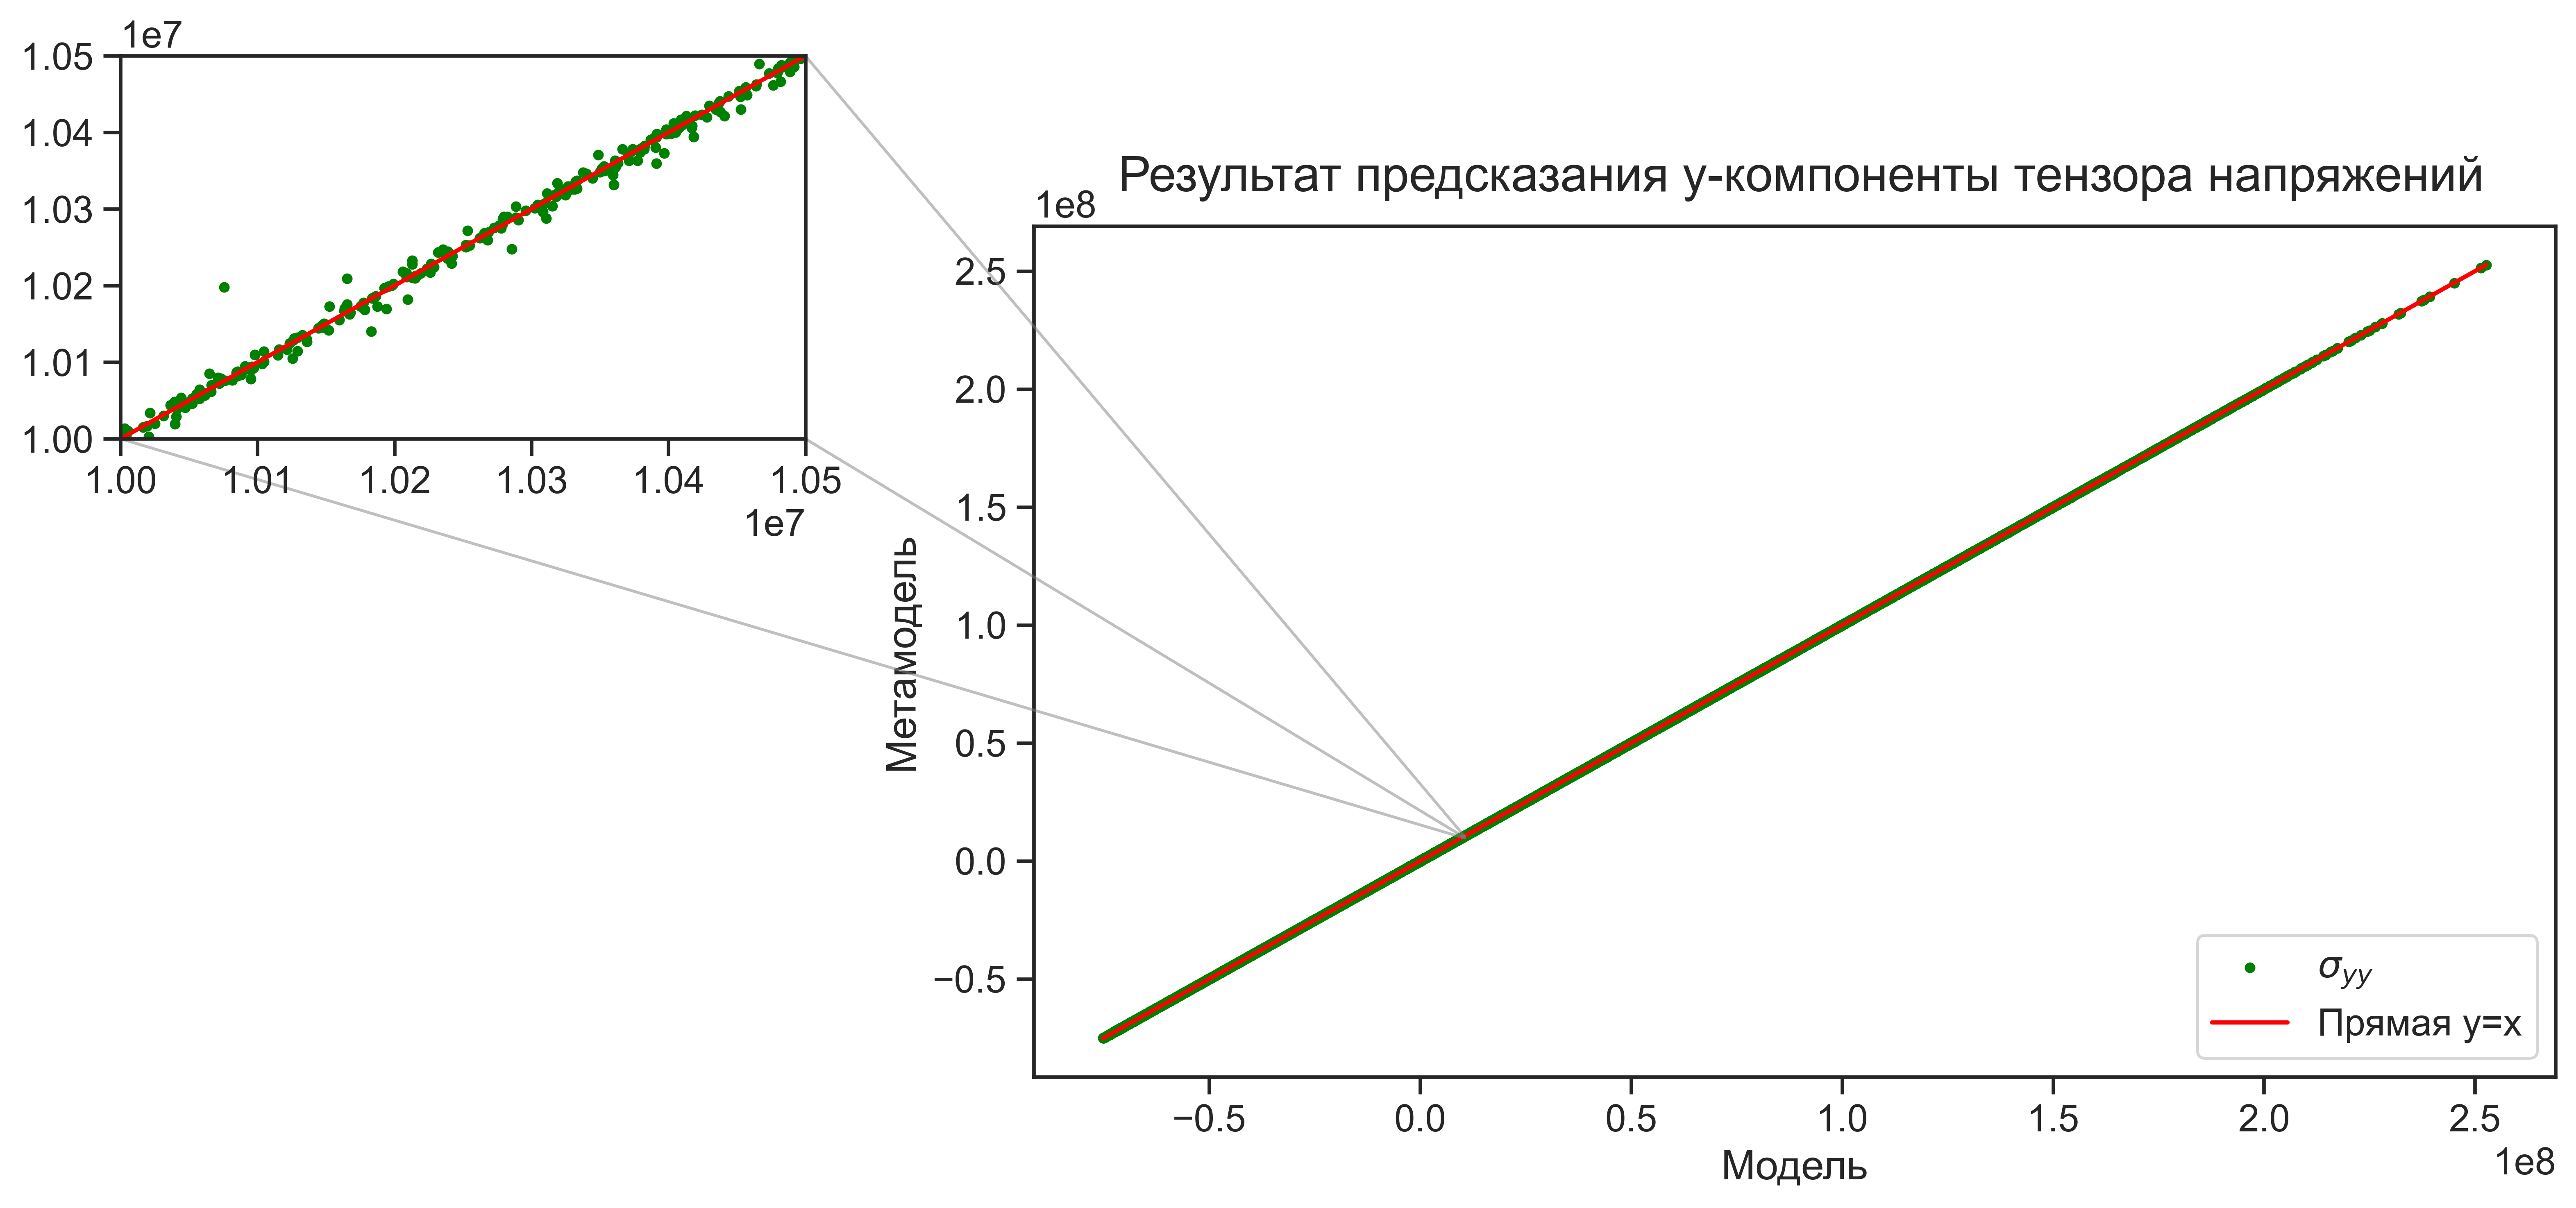

In [14]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=250)
axins = ax.inset_axes([-0.6, 0.75, 0.45, 0.45])


ax.scatter(test_output[0, :, 1], chaos_output[0, :, 1], color='green', marker='.', label='$\sigma_{yy}$', s=30)
ax.scatter(np.ravel(test_output[1:, :, 1]), np.ravel(chaos_output[1:, :, 1]), color='green', marker='.', s=30)

ax.plot([np.min(test_output[..., 1]), np.max(test_output[..., 1])],
        [np.min(test_output[..., 1]), np.max(test_output[..., 1])],
        color ='red', label='Прямая y=x')
ax.set_xlabel('Модель')
ax.set_ylabel('Метамодель')
ax.legend()

axins.scatter(np.ravel(test_output[:, :, 1]), np.ravel(chaos_output[:, :, 1]), color='green',
              marker='.', label='$\sigma_{yy}$', s=30)
axins.plot([1e7, 1.05e7], [1e7, 1.05e7], color ='red', label='Прямая y=x')
axins.set_xlim(1e7, 1.05e7)
axins.set_ylim(1e7, 1.05e7)

rectpatch, connects = ax.indicate_inset_zoom(axins, edgecolor="grey")
connects[0].set_visible(True)
connects[1].set_visible(False)
connects[2].set_visible(True)
connects[3].set_visible(True)


fig.suptitle('Результат предсказания y-компоненты тензора напряжений', x=0.91, y=1.05)
fig.tight_layout(rect=(0, 0, 1.3, 1.3))
plt.show()

Measure the error.

In [15]:
# Empirical error
emp_error = metrics.empirical_error(test_output, chaos_output)
print(f'Empirical error:\n{emp_error}\n')

# R-squared
r_sqr = metrics.r_squared(test_output, chaos_output)
print(f'R-squared:\n{r_sqr}\n')

# MAE
abs_error = metrics.mean_absolute_error(test_output, chaos_output)
print(f'Mean absolute error:\n{abs_error}\n')

# rMAE
rel_abs_error = metrics.relative_mean_absolute_error(test_output, chaos_output)
print(f'Relative mean absolute error:\n{rel_abs_error}\n')

Empirical error:
[[5.16522976e+08 2.31250510e+09]
 [4.25927850e+08 1.41872328e+09]
 [5.89308677e+07 4.20218546e+08]
 ...
 [1.08796104e+09 1.63731223e+08]
 [1.79718168e+09 1.55559915e+08]
 [1.65679774e+09 1.27729885e+08]]

R-squared:
[[0.99999996 0.99991762]
 [0.99999996 0.99991756]
 [0.99999993 0.99999966]
 ...
 [0.99999968 0.99999943]
 [0.99999963 0.99999965]
 [0.99999956 0.9999998 ]]

Mean absolute error:
[[16628.81391835 34375.94023233]
 [15069.8517722  27103.78550592]
 [ 5751.81807173 14609.42276723]
 ...
 [24686.05946458  9594.09901857]
 [31951.06736255  9412.30665266]
 [30657.35752128  8526.28183485]]

Relative mean absolute error:
[[0.00031733 0.00058103]
 [0.0003562  0.00048981]
 [0.00018929 0.00062083]
 ...
 [0.00020818 0.00021432]
 [0.00024825 0.00023521]
 [0.00025476 0.00024139]]



Average the error over the mesh nodes.

In [16]:
# Average Empirical error
avg_emp_error = np.mean(emp_error, axis=0)
print(f'Average empirical error:\n{avg_emp_error}\n')

# Average R-squared
avg_r_sqr = np.mean(r_sqr, axis=0)
print(f'Average r-squared:\n{avg_r_sqr}\n')

# Average MAE
avg_abs_error = np.mean(abs_error, axis=0)
print(f'Average mean absolute error:\n{avg_abs_error}\n')

# Average rMAE
avg_rel_abs_error = np.mean(rel_abs_error, axis=0)
print(f'Average relative mean absolute error:\n{avg_rel_abs_error}\n')

Average empirical error:
[1.77231101e+09 7.81055708e+08]

Average r-squared:
[0.99999929 0.99998746]

Average mean absolute error:
[27459.86464645 15286.34651826]

Average relative mean absolute error:
[0.00053454 0.00134168]



Plot the error.

In [17]:
# Import cell and point data
with open(r'files/mesh.pickle', 'rb') as f:
    cells = np.array(pickle.load(f))
    points = np.array(pickle.load(f))

# Define cell types
celltypes = np.full(len(cells), fill_value=CellType.TETRA, dtype=np.uint8)

In [18]:
# Define a mesh
grid = pv.UnstructuredGrid(cells, celltypes, points)
grid

UnstructuredGrid,Information
N Cells,5029
N Points,1588
X Bounds,"-1.000e-01, 1.000e-01"
Y Bounds,"-1.000e-01, 1.000e-01"
Z Bounds,"0.000e+00, 5.000e-03"
N Arrays,0


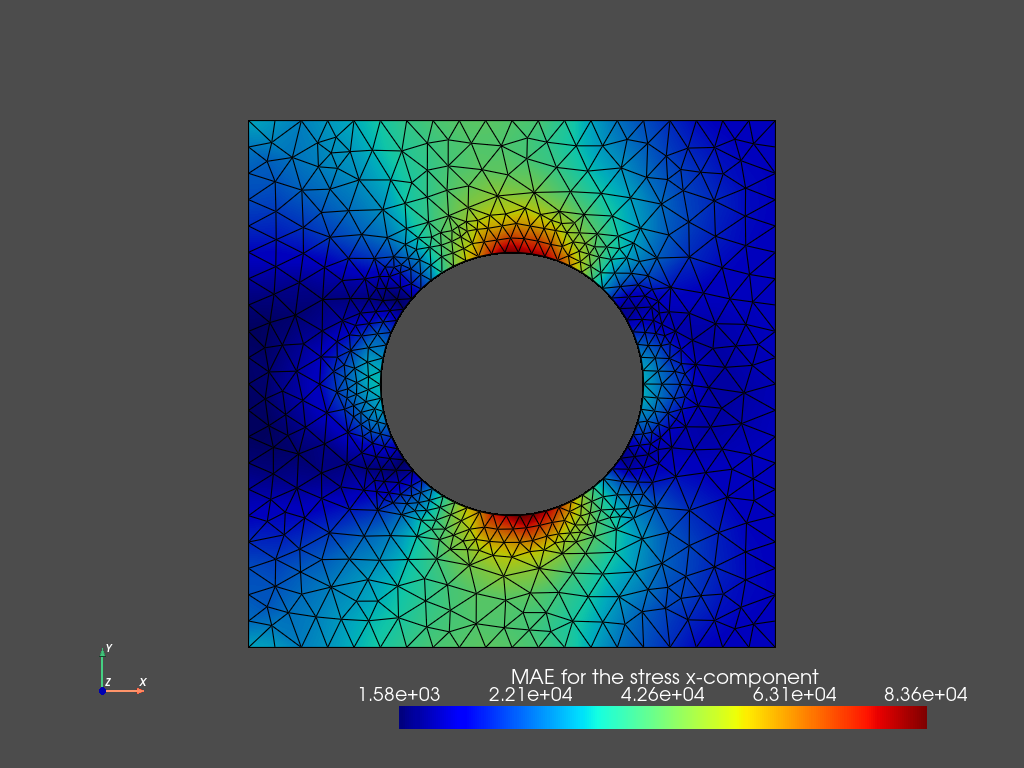

In [19]:
# Plot the nodal MAE for the x-component
grid.point_data['MAE for the stress x-component'] = abs_error[:, 0]
grid.plot(show_edges=True, cpos='XY')

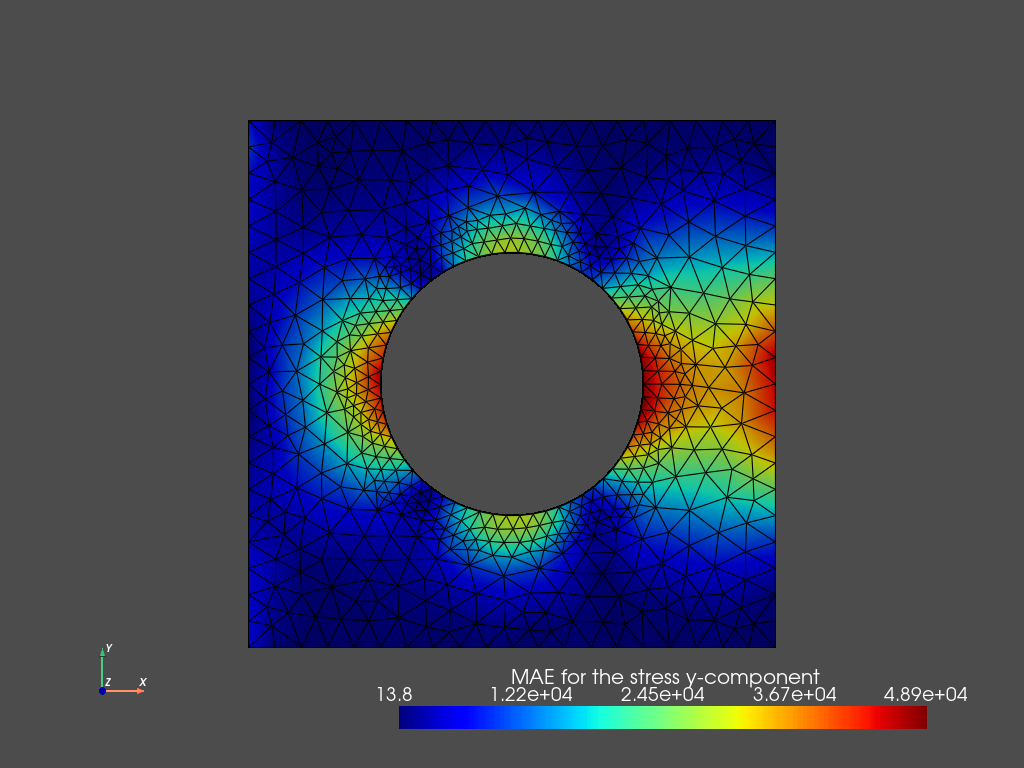

In [20]:
# Plot the nodal MAE for the y-component
grid.point_data.clear()
grid.point_data['MAE for the stress y-component'] = abs_error[:, 1]
grid.plot(show_edges=True, cpos='XY')

Create a DataFrame containing the node coordinates and the corresponding expansions.

In [21]:
df_expan = pd.DataFrame(points.tolist(), columns=['X', 'Y', 'Z'])
df_expan[['PCE $\sigma_{xx}$', 'PCE $\sigma_{yy}$']] = list(map(lambda x: [str(x[0]), str(x[1])], approx_solver.round(4)))
df_expan

,X,Y,Z,PCE $\sigma_{xx}$,PCE $\sigma_{yy}$
0,-0.045807,-0.020042,0.0050,0.0102*q0*q1+0.0001*q0**2+584.6021*q1-1017015....,0.0506*q0*q1+0.0005*q0**2+2907.6356*q1-5068863...
1,-0.056604,-0.019940,0.0000,0.0011*q0*q1+66.8645*q1-115130.4625*q0-4230460...,0.0283*q0*q1+0.0003*q0**2+1628.2602*q1-2839257...
2,-0.048476,-0.036996,0.0000,-0.0365*q0*q1-0.0004*q0**2-2096.9507*q1+365322...,0.0236*q0*q1+0.0002*q0**2+1354.9997*q1-2362033...
3,-0.034197,-0.036477,0.0000,-0.0324*q0*q1-0.0003*q0**2-1860.9166*q1+324057...,0.002*q0*q1+114.6084*q1-200240.2132*q0+1587178...
4,-0.034197,-0.036477,0.0025,-0.0257*q0*q1-0.0003*q0**2-1480.8306*q1+257864...,0.0066*q0*q1+0.0001*q0**2+381.1293*q1-664789.8...
...,...,...,...,...,...
1583,-0.100000,-0.069970,0.0000,0.0001*q1**2-0.115*q0*q1-0.0012*q0**2-6615.027...,-0.0396*q0*q1-0.0004*q0**2-2277.8546*q1+396831...
1584,-0.100000,-0.079966,0.0000,0.0001*q1**2-0.1364*q0*q1-0.0014*q0**2-7842.51...,-0.0543*q0*q1-0.0006*q0**2-3123.3764*q1+544146...
1585,-0.100000,-0.089962,0.0000,0.0001*q1**2-0.1626*q0*q1-0.0017*q0**2-9349.06...,-0.0631*q0*q1-0.0007*q0**2-3628.4085*q1+632152...
1586,-0.100000,0.100000,0.0000,0.0001*q1**2-0.2051*q0*q1-0.0022*q0**2-11792.8...,-0.061*q0*q1-0.0006*q0**2-3506.0256*q1+6108401...


In [22]:
# Export as .xlsx
# df_expan.to_excel("files/Nodal PCE.xlsx")